In [1]:
import os
import sys
import pathlib
import math
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline 

import numpy as np
import pandas as pd

from IPython.display import clear_output
from datetime import datetime
import re

In [2]:
ids = os.listdir("E:/UG4data/Smile")
ids.remove("PRB002")
ids.remove("PRB111")
long_ids = [f[:-14] for f in os.listdir(f"E:/UG4data/NHS_processed")]

## Visualize HAR results

In [ ]:
# Codes for HAR activity types classification is in projenv/Classification HAR.ipynb

In [3]:
def load_file(id):
    files = [f[:-14] for f in os.listdir("results/NHS/HAR_resampled") if f.startswith(id)]
    df_agg = pd.DataFrame()
    for long_id in files:
        df_act = pd.read_csv(f"results/NHS/HAR_resampled/{long_id}_resampled.csv", parse_dates=["timestamp"], index_col=["timestamp"])
        df = pd.read_csv(f"E:/UG4data/NHS_r1min/{long_id}_r1min.csv", parse_dates=["timestamp"], index_col=["timestamp"])
        df = df.merge(df_act, on="timestamp", how="outer")
        df["file"] = int(re.search(r'\((\d+)\)', long_id).group(1))
        df_agg = pd.concat([df_agg, df])

    df_agg["date"] = df_agg.index.floor("D")
    df_agg["id"] = id
    df_agg = df_agg.rename(columns={'final_class': 'activity_type'})
    return df_agg

In [4]:
NEW_ACTIVITY_DESCRIPTIONS = {
    0: "Ascending stairs",
    1: 'Cycling',
    2: 'Descending stairs',
    3: 'Lying on back',
    4: 'Lying on left side',
    5: 'Lying on right side',
    6: 'Lying on stomach',
    7: 'Movement',
    8: 'Not worn',
    9: 'Running',
    10: 'Shuffling',
    11: 'Sitting/Standing',
    12: 'Walking'
}
stationary_activities = [3, 4, 5, 6, 11]

In [5]:
ACTIVITY_COLOR = {
    'Ascending stairs': "orchid",
    'Cycling': "darkviolet",
    'Descending stairs': "hotpink",
    'Lying on back': "olivedrab",
    'Lying on left side': "limegreen",
    'Lying on right side': "mediumseagreen",
    'Lying on stomach': "lightseagreen",
    'Movement': "indianred",
    'Not worn': "silver",
    'Running': "red",
    'Shuffling': "chocolate",
    'Sitting/Standing': "royalblue",
    'Walking': "orange" 
}

ACTIVITY_COLOR_NUM = {
    0: "orchid",
    1: "darkviolet",
    2: "hotpink",
    3: "olivedrab",
    4: "limegreen",
    5: "mediumseagreen",
    6: "lightseagreen",
    7: "indianred",
    8: "silver",
    9: "red",
    10: "chocolate",
    11: "royalblue",
    12: "orange" 
}

In [6]:
def activity_type_counts(id):
    df = load_file(id)
    if len(df) == 0:
        return
    activity_counts = [0]*13
    for i, activity in NEW_ACTIVITY_DESCRIPTIONS.items():
        activity_counts[i] = len(df[df["activity_type"] == i])
        
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.bar(range(13), activity_counts, color=ACTIVITY_COLOR.values())
    ax.set_xticks(range(13), NEW_ACTIVITY_DESCRIPTIONS.values(), rotation=45, horizontalalignment='right')
    ax.set_title(f"Sum of all activity types recorded for {id}")
    ax.set_ylabel('Number', fontsize = 10)
    ax.set_xlabel('Activity Name')
    for i in range(13):
        plt.text(i-0.25, activity_counts[i], activity_counts[i])
    plt.tight_layout()
#     plt.savefig(f"results/NHS/graphs/HAR_1min/{id}.png", dpi=200)
    plt.show()
    return activity_counts

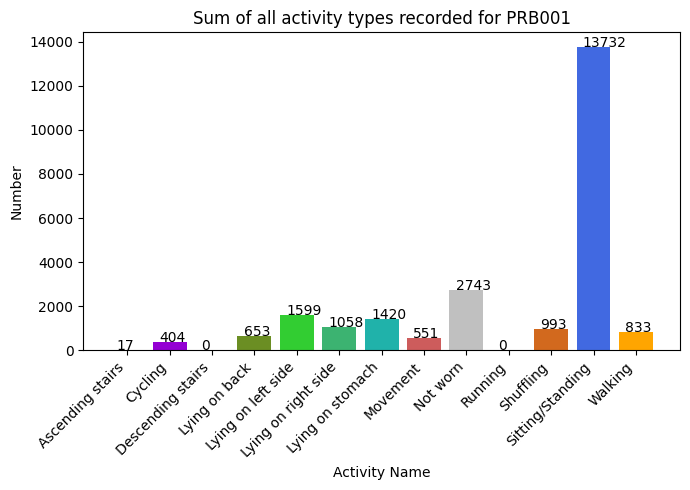

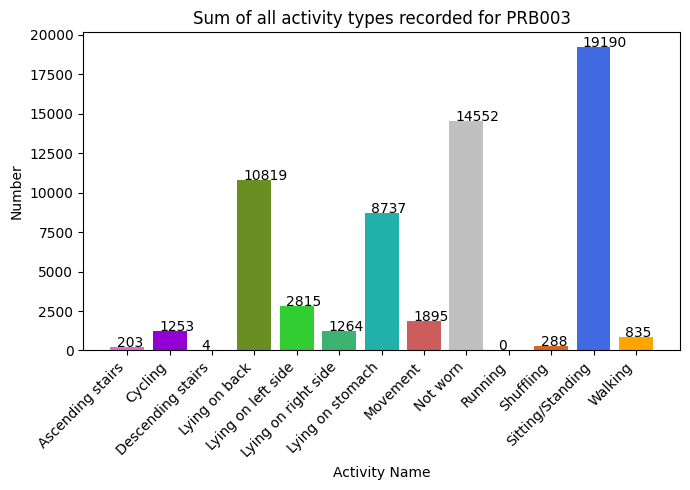

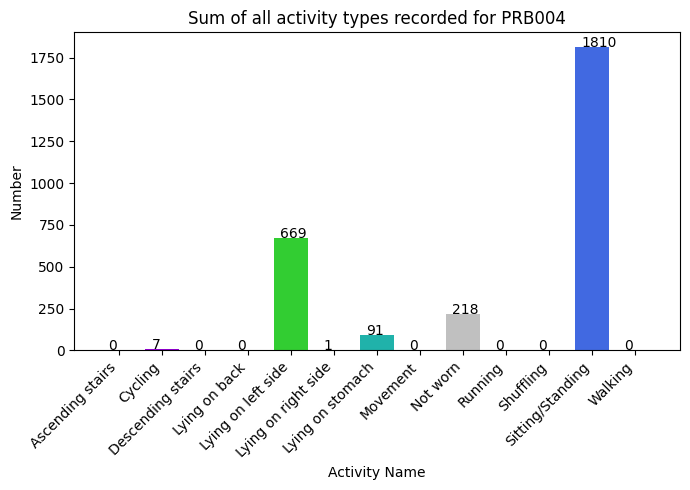

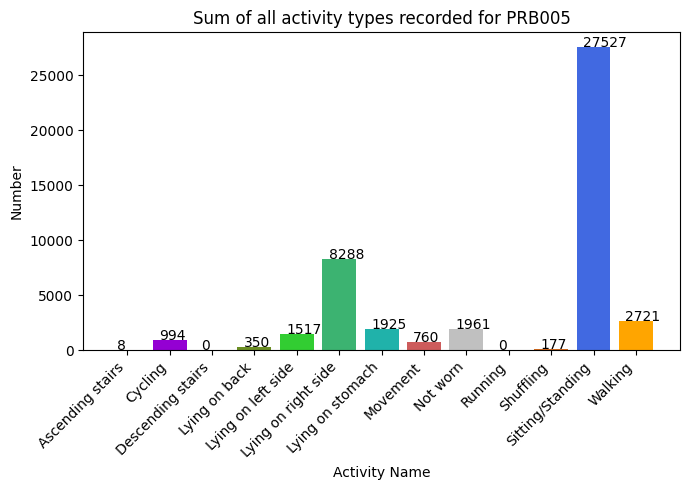

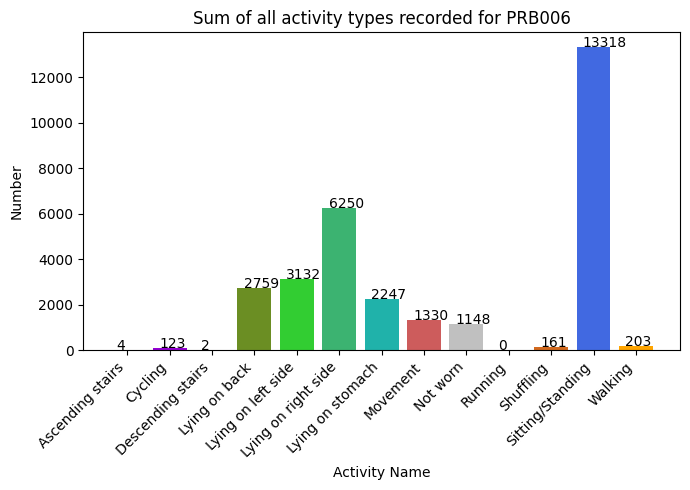

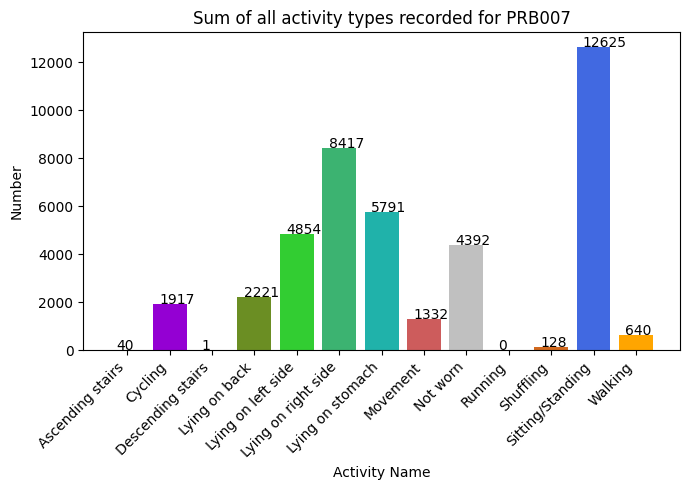

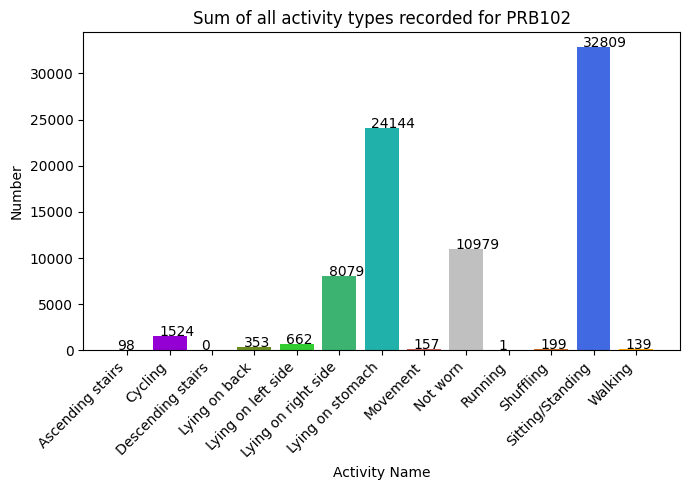

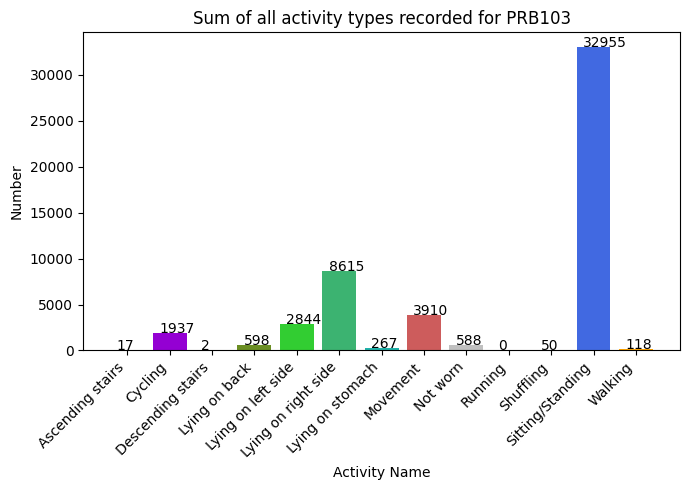

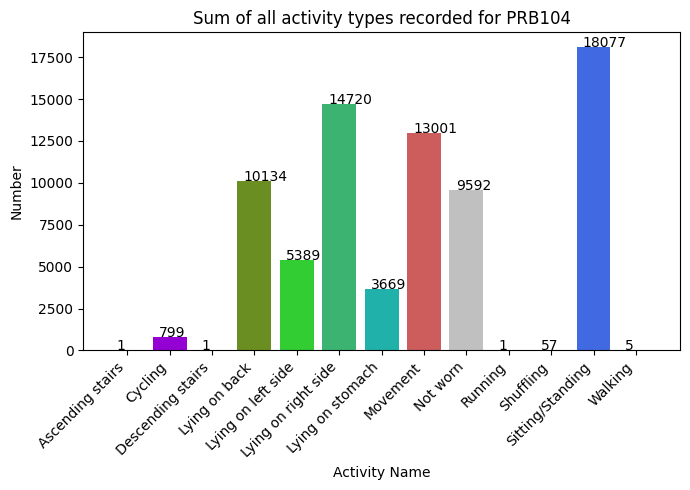

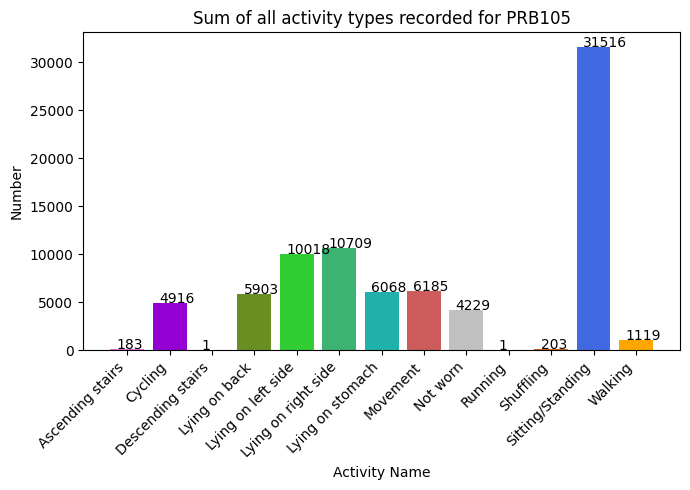

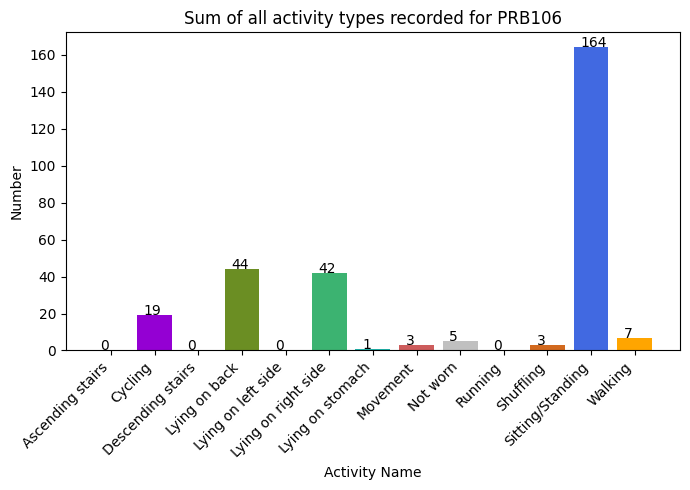

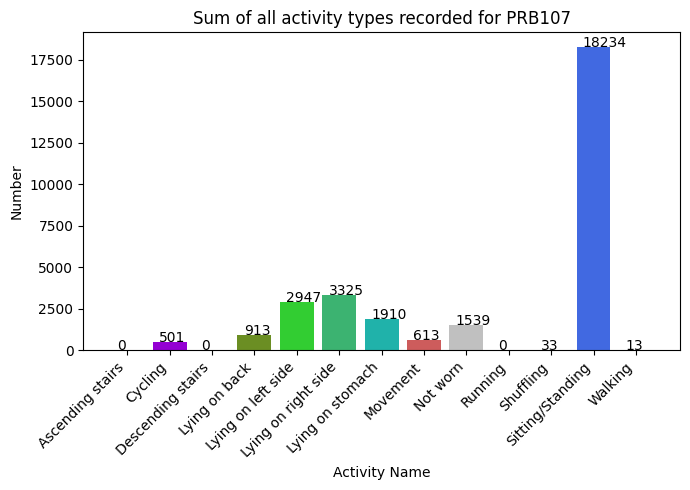

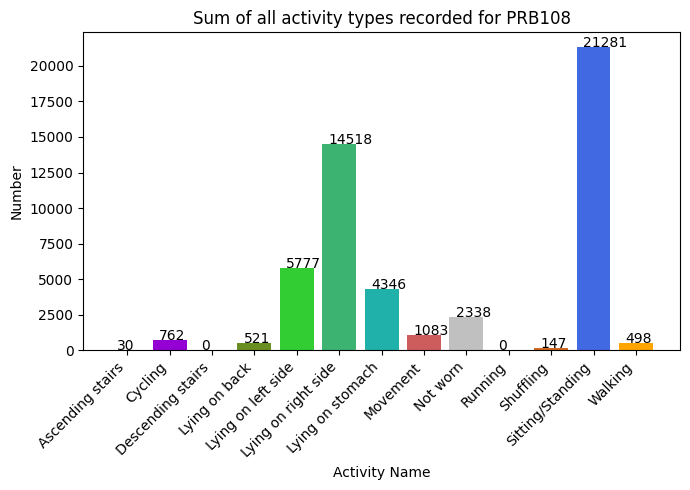

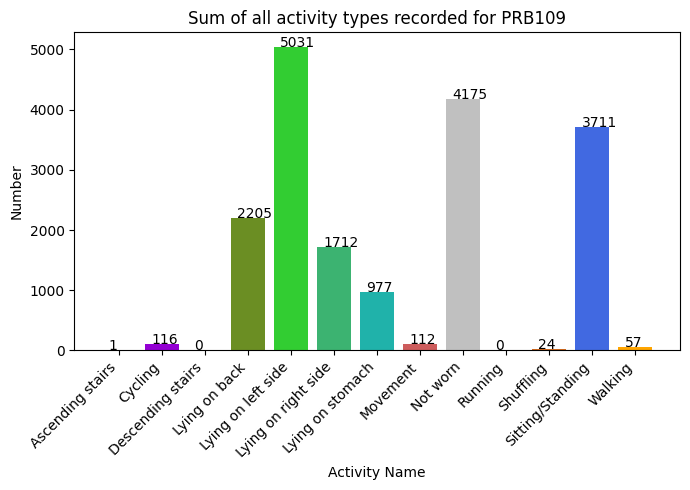

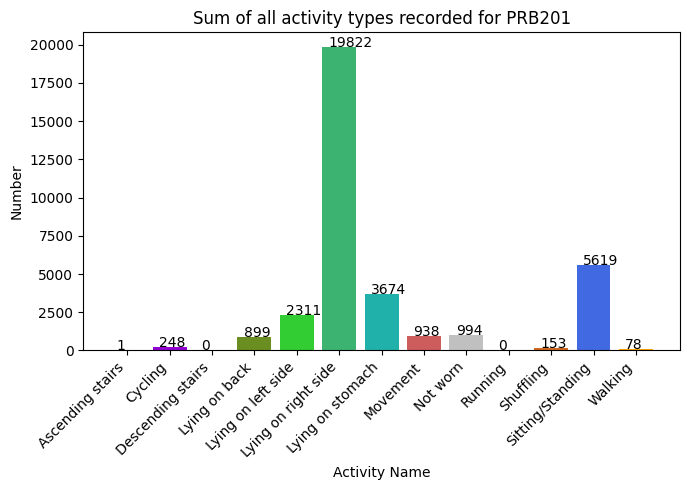

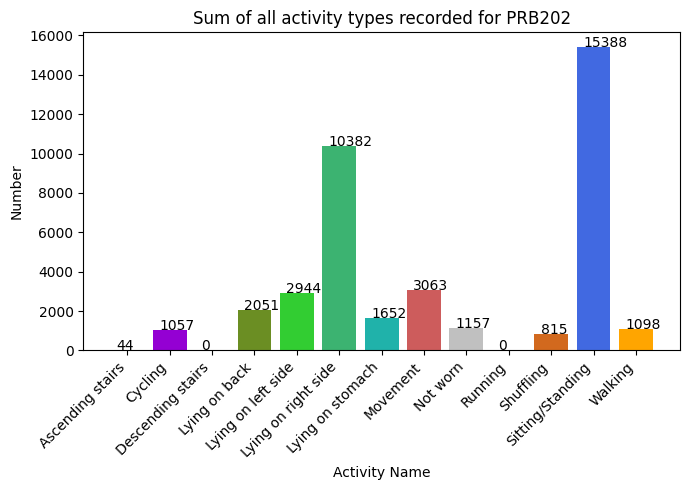

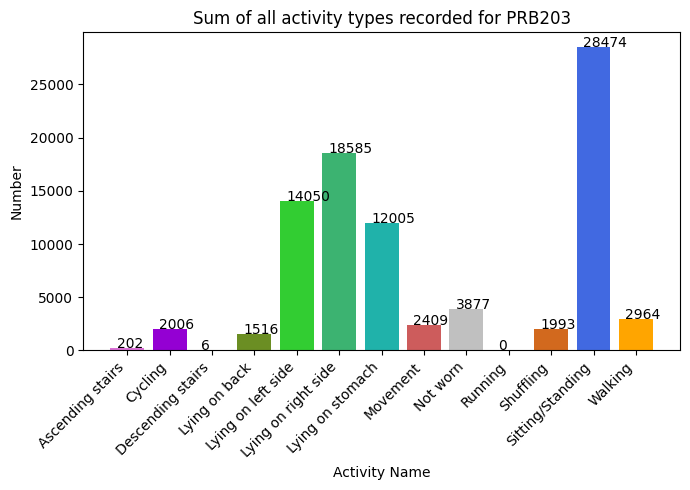

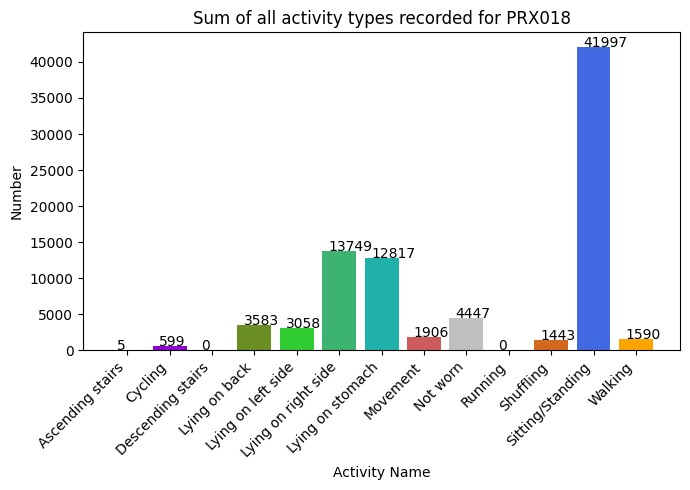

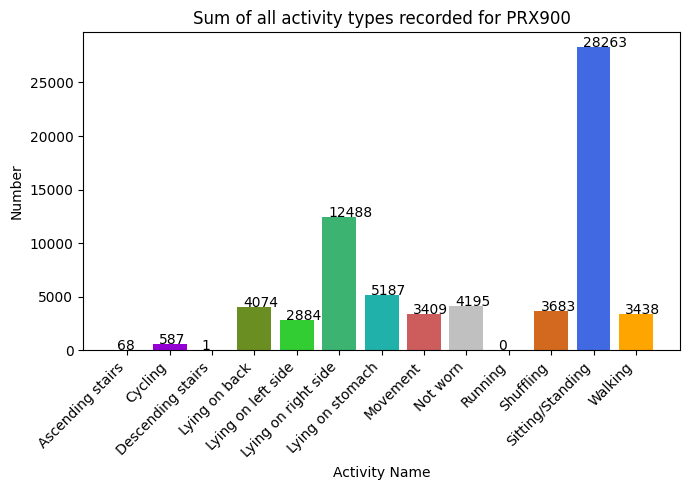

In [8]:
activity_counts_sum = [0]*13
for id in ids:
    counts = activity_type_counts(id)
    activity_counts_sum = [x + y for x, y in zip(activity_counts_sum, counts)]

In [88]:
49596+72501+162024+96928+366690

747739

In [91]:
747739 / sum(activity_counts_sum)

0.8206604232266504

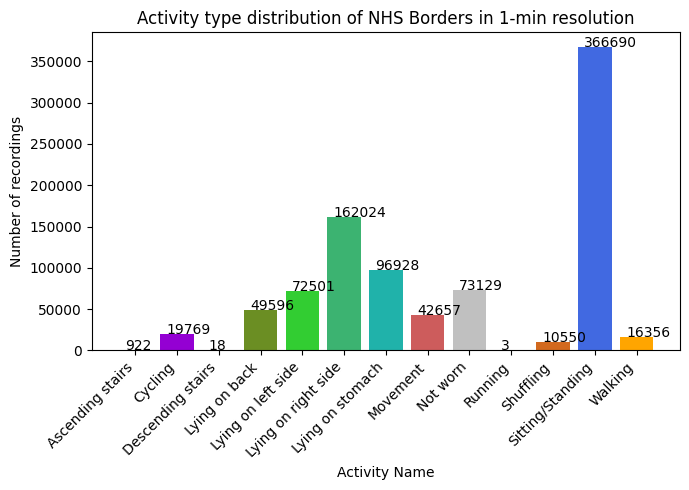

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(range(13), activity_counts_sum, color=ACTIVITY_COLOR.values())
ax.set_xticks(range(13), NEW_ACTIVITY_DESCRIPTIONS.values(), rotation=45, horizontalalignment='right')
ax.set_title("Activity type distribution of NHS Borders in 1-min resolution")
ax.set_ylabel('Number of recordings', fontsize = 10)
ax.set_xlabel('Activity Name')

for i in range(13):
    plt.text(i-0.25, activity_counts_sum[i], activity_counts_sum[i])
plt.tight_layout()
plt.savefig(f"results/NHS/graphs/HAR_sum/NHS_1min.png", dpi=200)
plt.show()

In [ ]:
# def mean_na(l):
#     if l.isna().sum() > len(l)/2:
#         return np.nan
#     else:
#         return l.mean()

In [7]:
def plot_day_activity(df):
    id = df["id"].iloc[0]
    date = df["date"].iloc[0].date()
    file = df["file"].iloc[0]
    title = f"{id} day {file} {date}"
    print("Plotting ", title)
    
    start_time = str(date) + ' 00:00:00'
    ind = pd.date_range(start=start_time, periods=24*60, freq='min')
    df = pd.DataFrame(df, index=ind)
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    # For 30s resolution
#     df['second'] = df.index.second
#     df.loc[df['second'] != 0, 'minute'] += 0.5
#     df.drop(['second'], axis=1, inplace=True)
    
    fig, axs = plt.subplots(ncols=3, figsize=(18, 6))
    
    heat_map = df.pivot(index='hour', columns='minute', values='breathingRate')
    sns.heatmap(heat_map, cmap=plt.cm.gray_r, ax=axs[0])
    axs[0].set_title("Breathing Rate", fontsize=15)
    axs[0].set_ylabel("hours", fontsize=12)
    
    heat_map = df.pivot(index='hour', columns='minute', values='activityLevel')
    sns.heatmap(heat_map, cmap=plt.cm.gray_r, ax=axs[1])
    axs[1].set_title("Activity Level", fontsize=15)
    
    heat_map = df.pivot(index='hour', columns='minute', values='activity_type')
    sns.heatmap(heat_map, vmin=0, vmax=12, cmap=sns.color_palette(ACTIVITY_COLOR_NUM.values()), ax=axs[2])
    cbar = axs[2].collections[0].colorbar
    cbar.set_ticks(list(np.linspace(0.5, 11.5, 13)))
    cbar.set_ticklabels(NEW_ACTIVITY_DESCRIPTIONS.values())
    axs[2].set_title("Activity Type", fontsize=15)

    hourly_timestamps = [t.strftime('%I:%M %p') for t in pd.date_range(start='00:00:00', end='23:00:00', freq='1h').tolist()]
    for i, ax in enumerate(axs):
        ax.set_xlabel("minutes", fontsize=12)
        for spine in ax.spines.values():
            spine.set_visible(True)
        if i == 0: 
            ax.set_yticks(ticks=np.arange(0.5, 24.5, 1), labels=hourly_timestamps, rotation=90)
            ax.tick_params(axis='y', rotation=360)
        else:
            ax.set(ylabel=None)
            ax.tick_params(labelleft = False)
    
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.savefig(f"results/NHS/graphs/HAR/{id}/{title}.png", dpi=300)
    plt.show()

In [8]:
data = load_file("PRB109")
dates = data['date'].unique()
dates = list(dates)
dates.sort()

Plotting  PRB109 day 1 2022-09-02


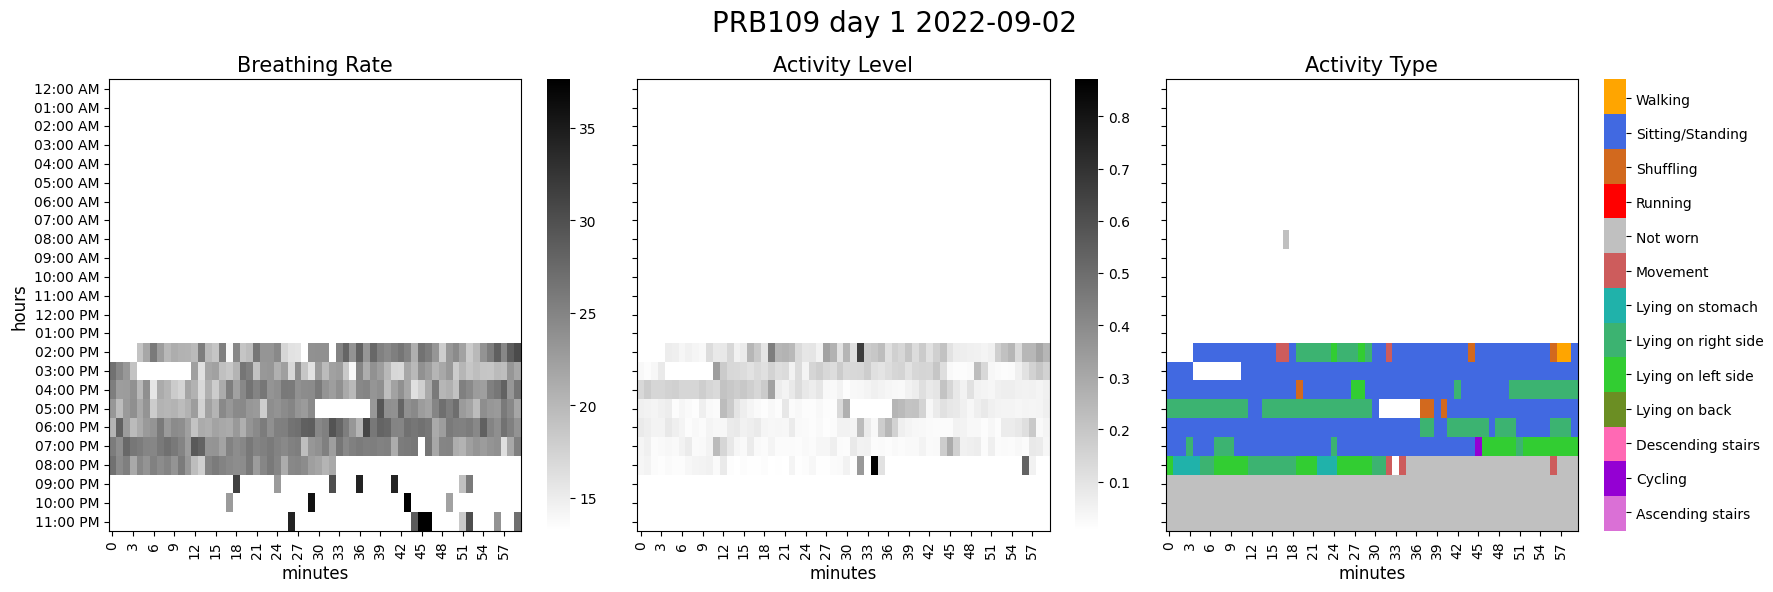

Plotting  PRB109 day 2 2022-09-03


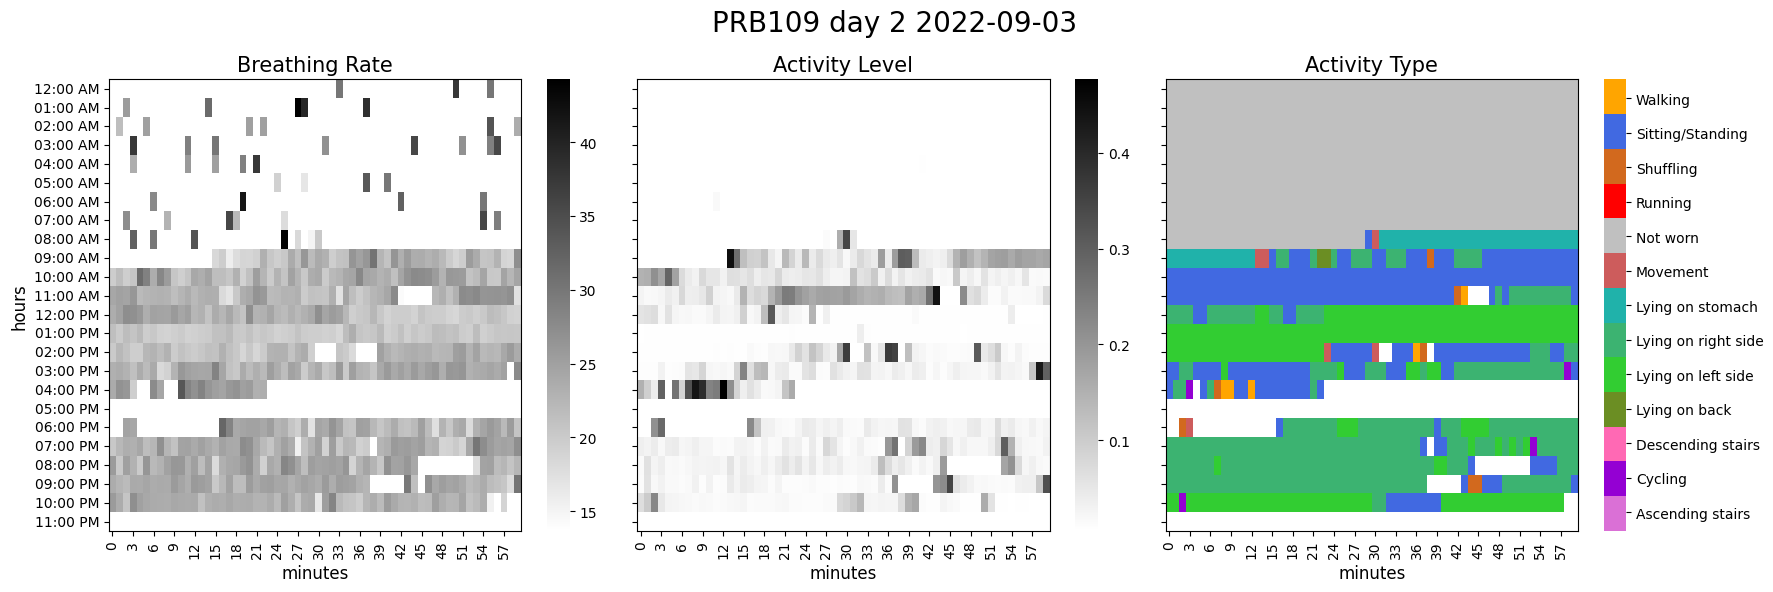

Plotting  PRB109 day 3 2022-09-04


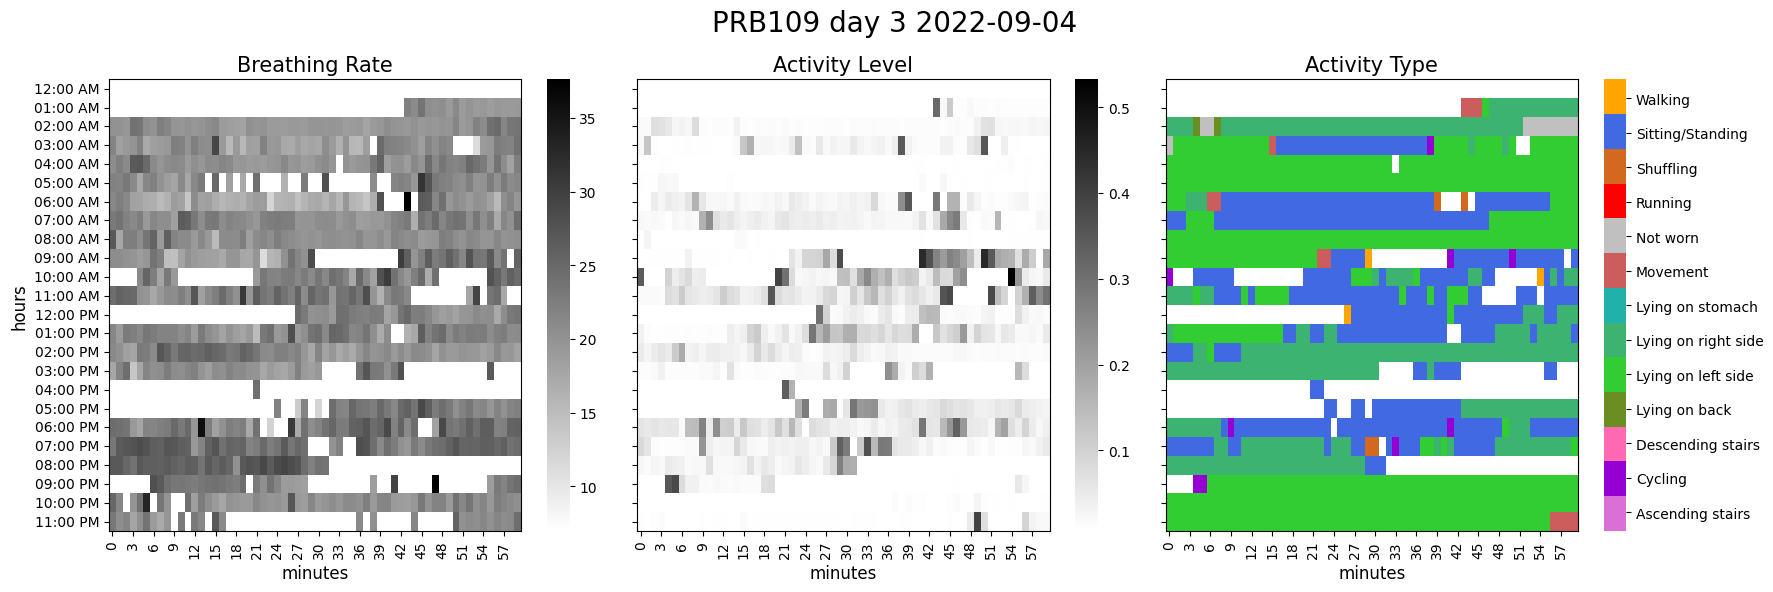

Plotting  PRB109 day 4 2022-09-05


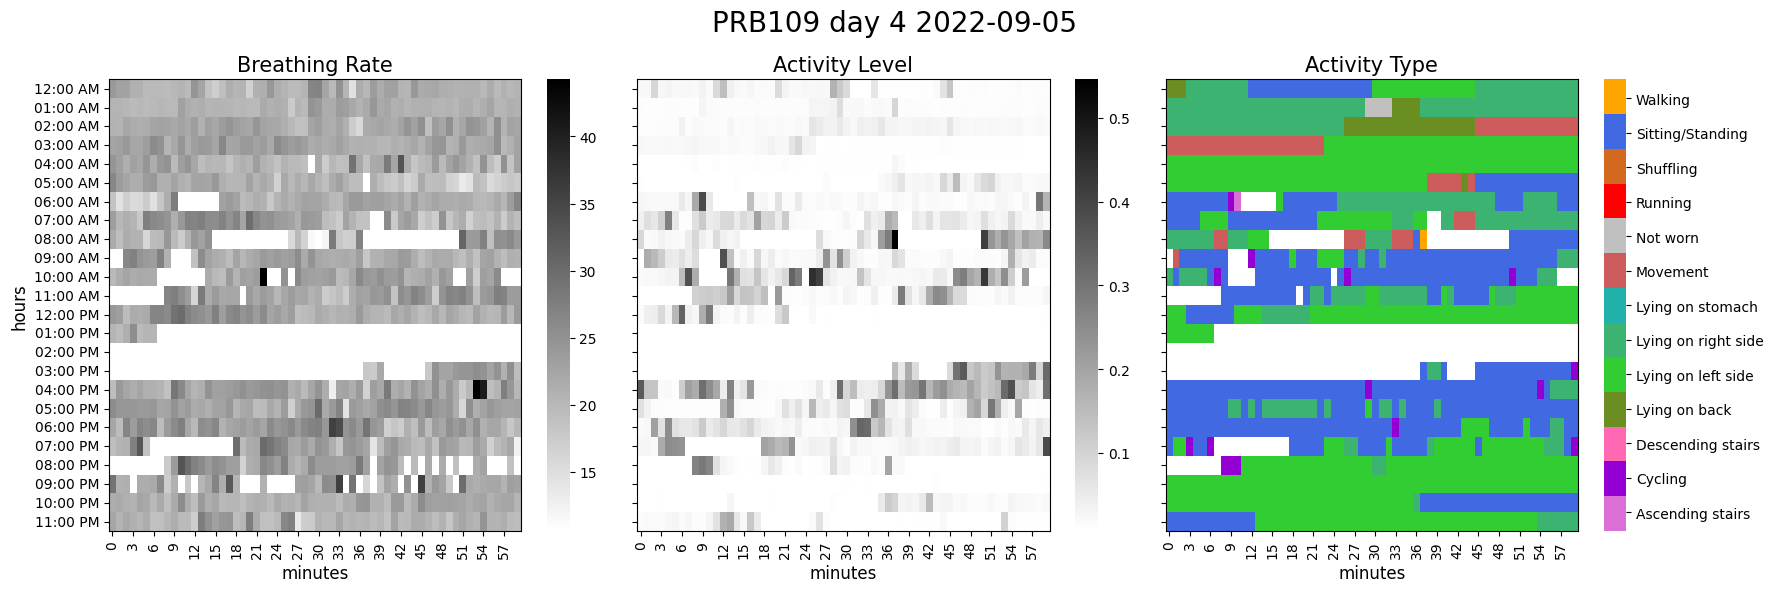

Plotting  PRB109 day 5 2022-09-06


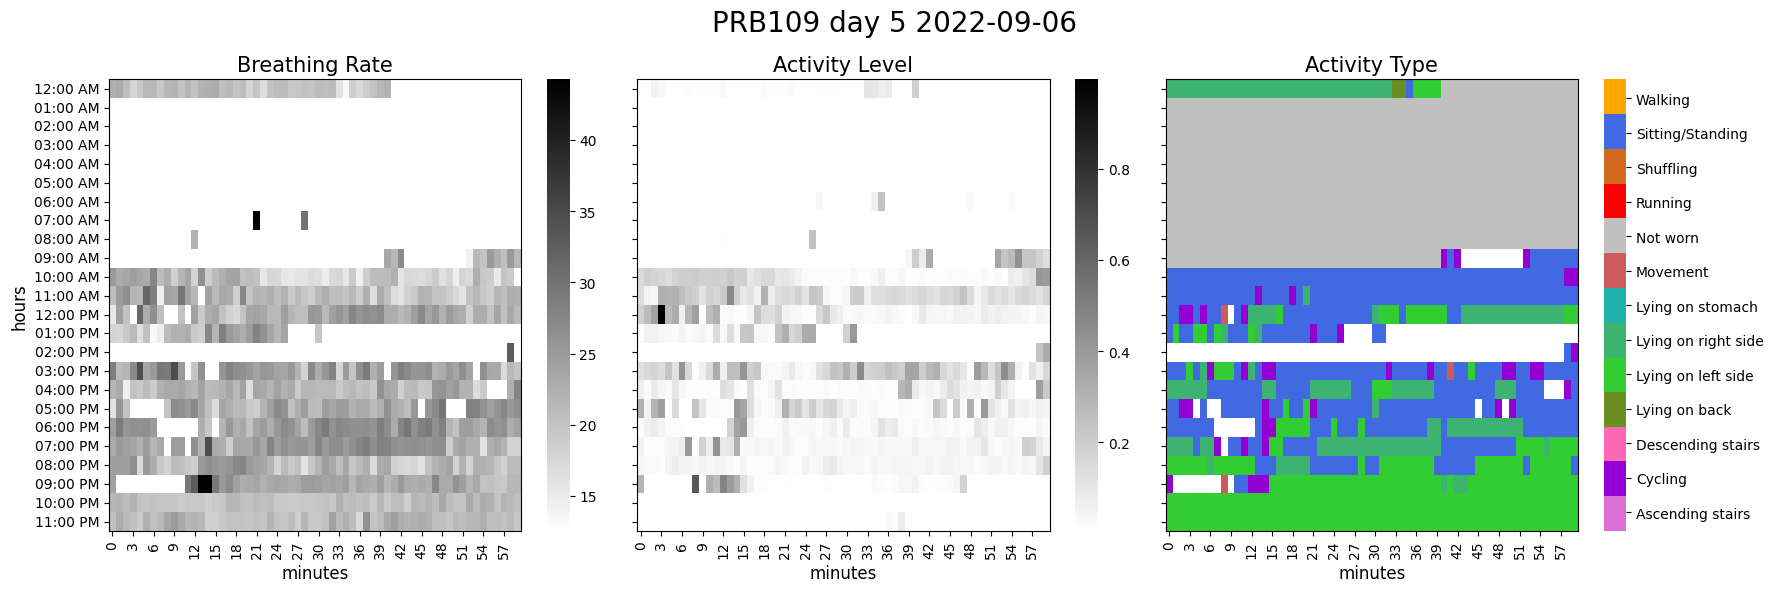

Plotting  PRB109 day 6 2022-09-07


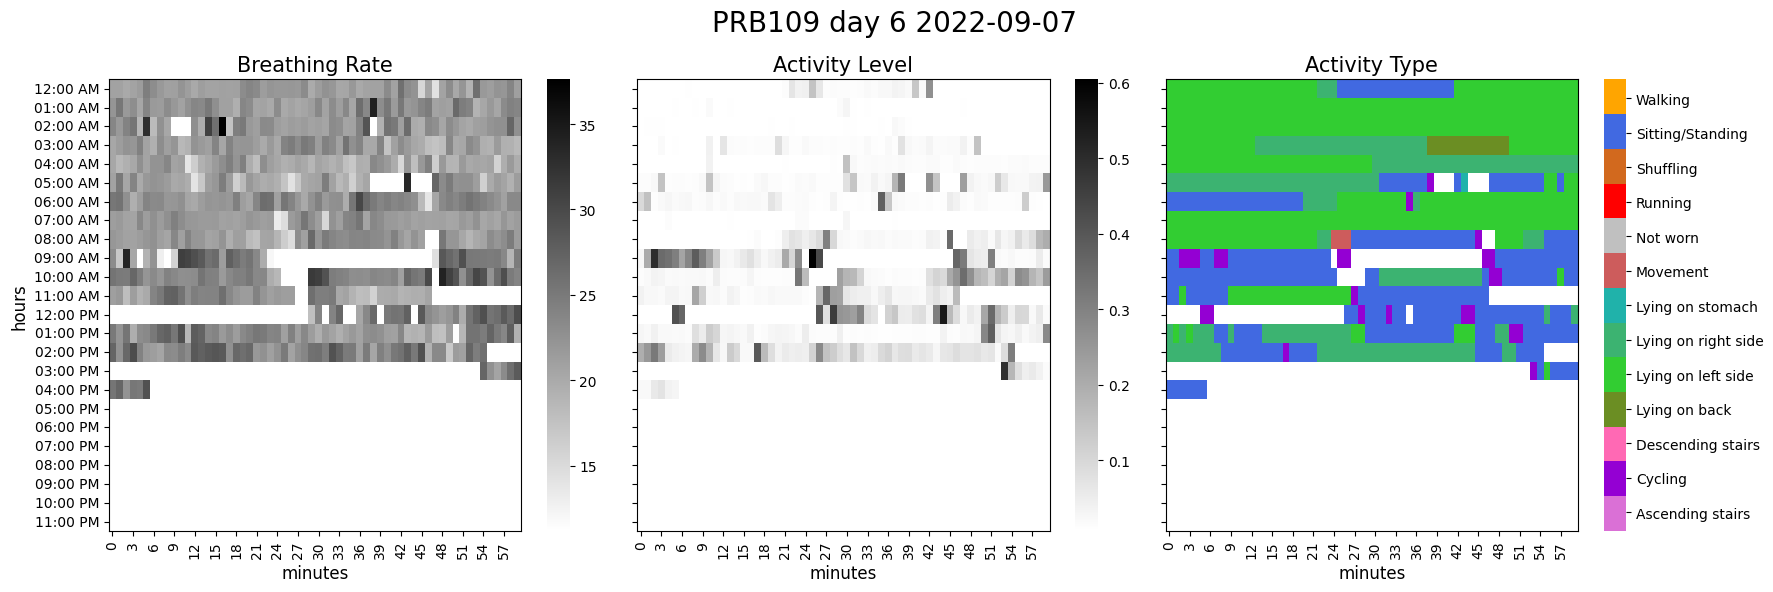

Plotting  PRB109 day 7 2022-09-08


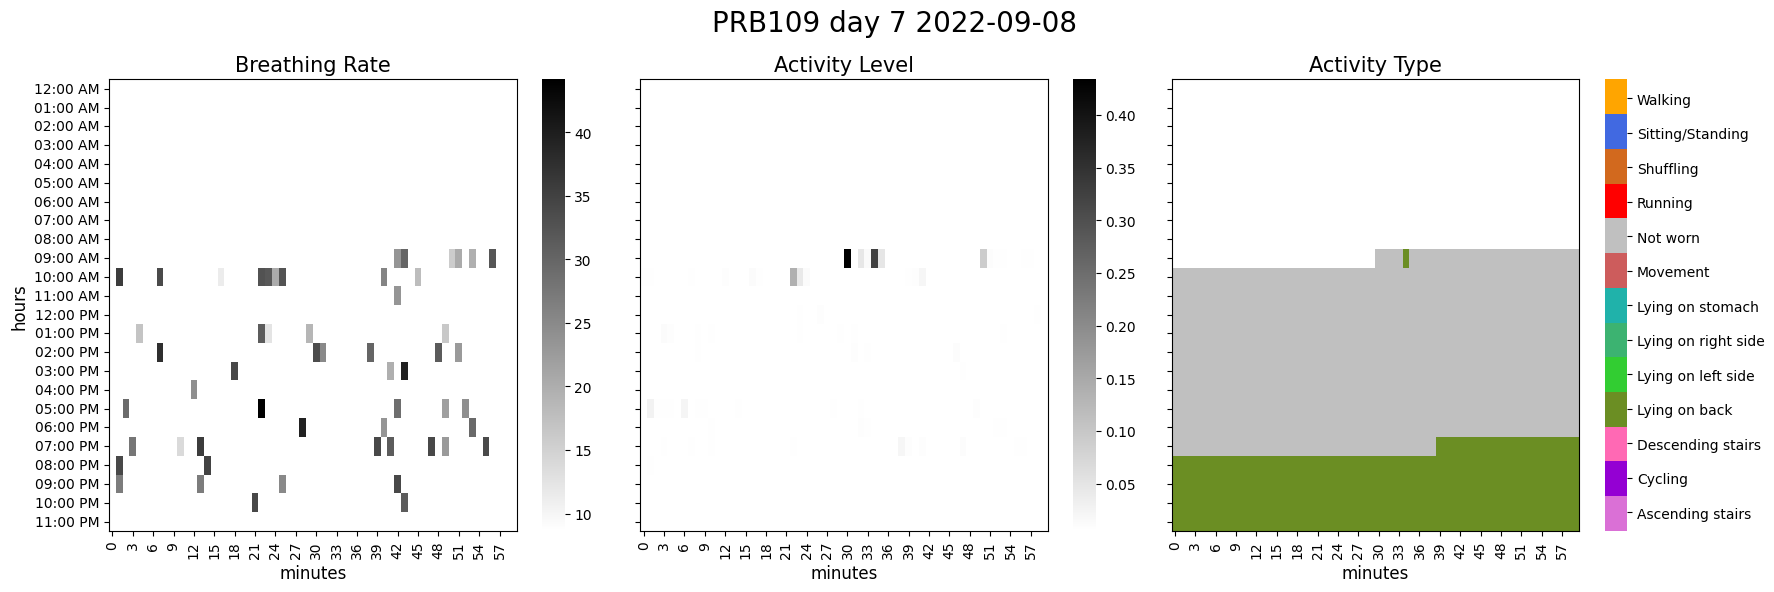

Plotting  PRB109 day 8 2022-09-09


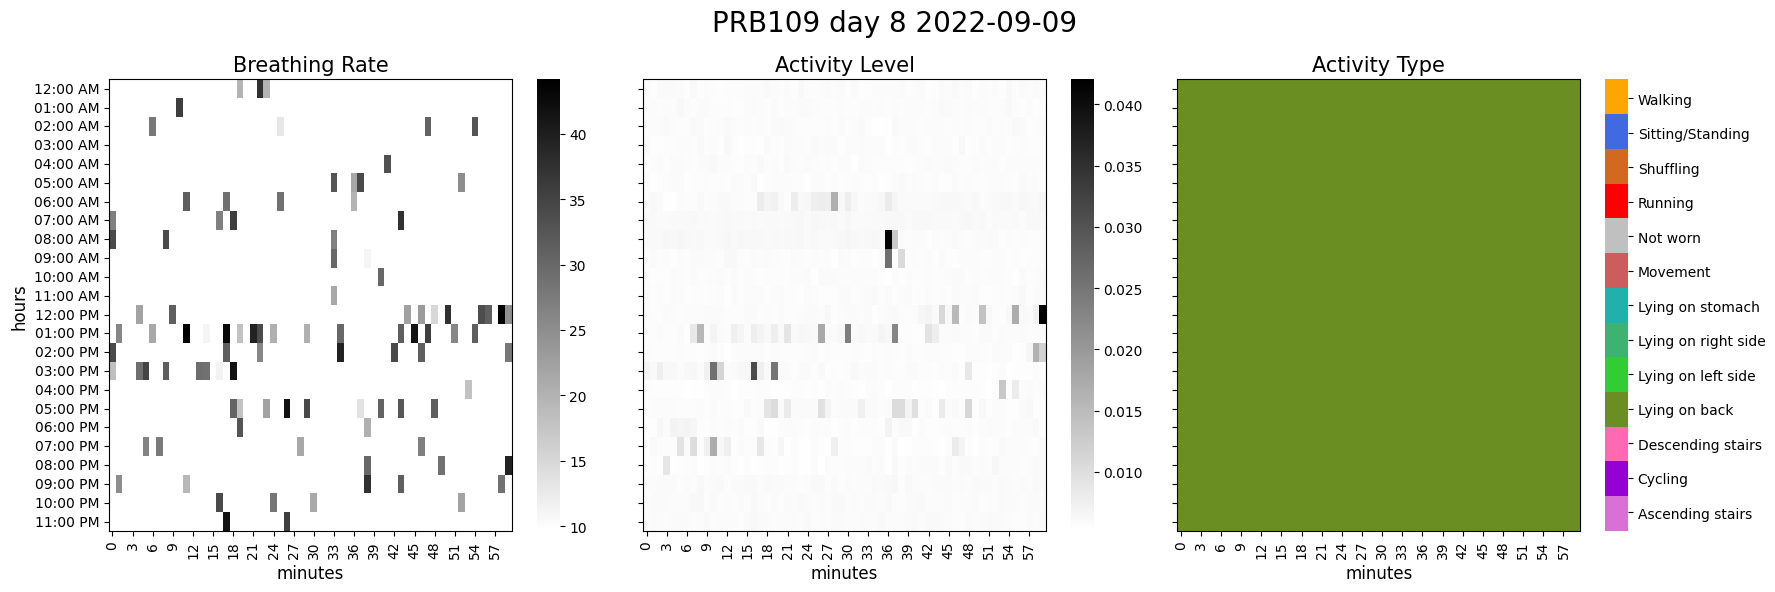

Plotting  PRB109 day 10 2022-09-10


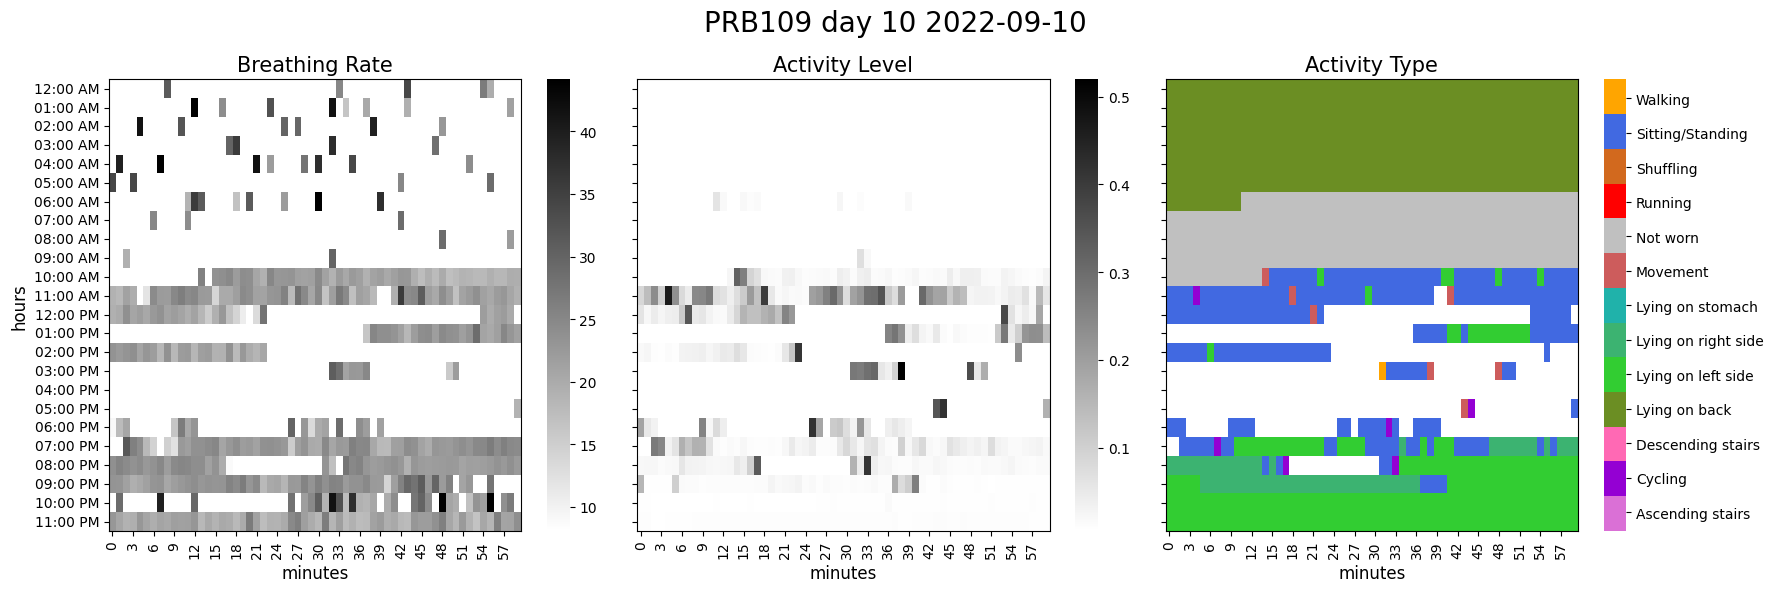

Plotting  PRB109 day 10 2022-09-11


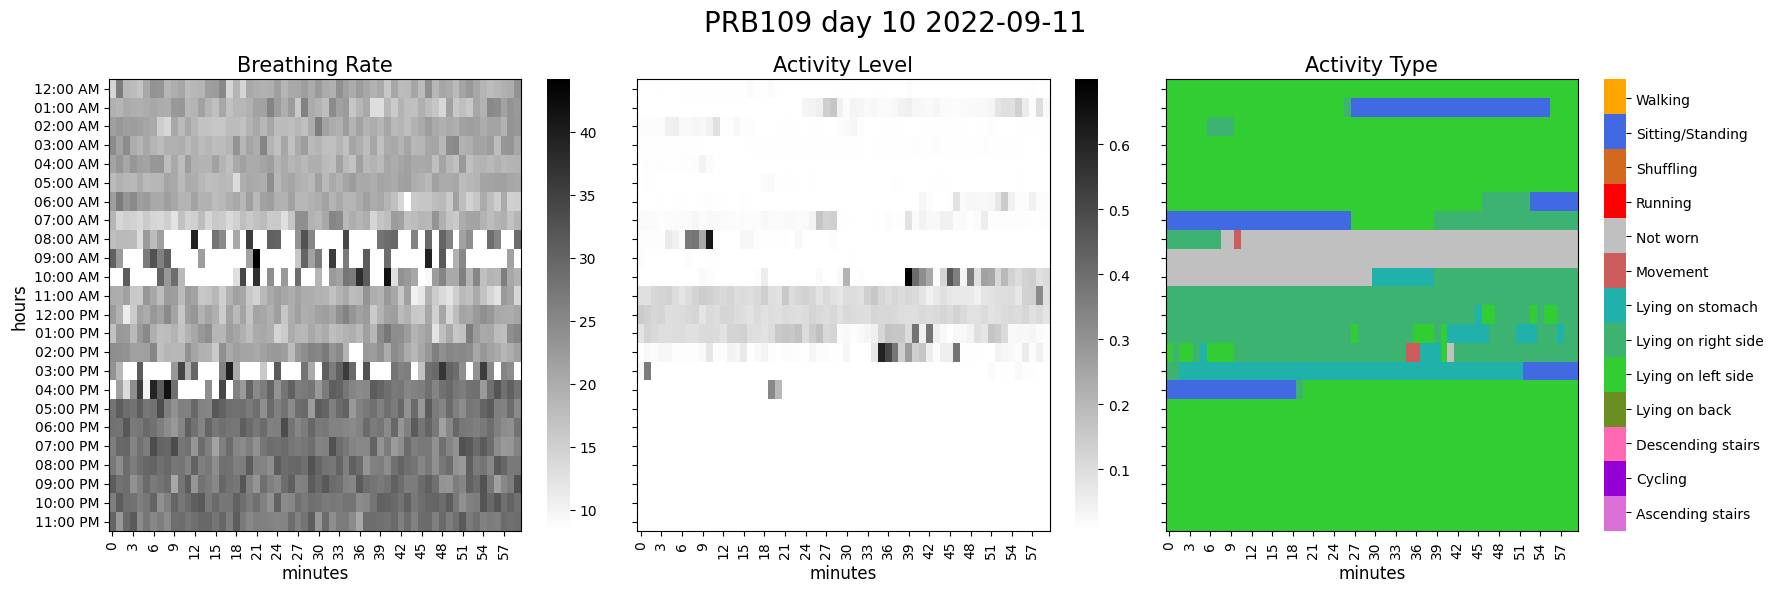

Plotting  PRB109 day 11 2022-09-12


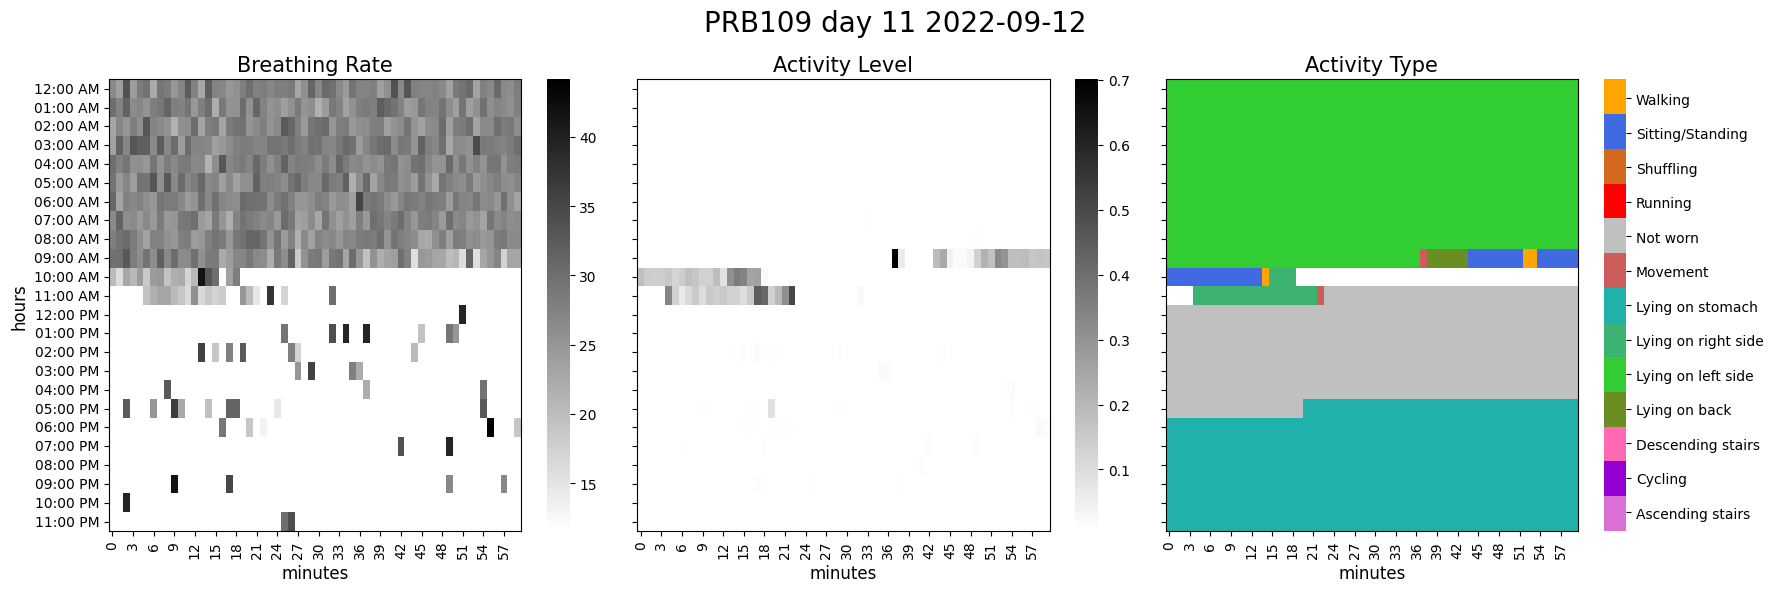

Plotting  PRB109 day 12 2022-09-13


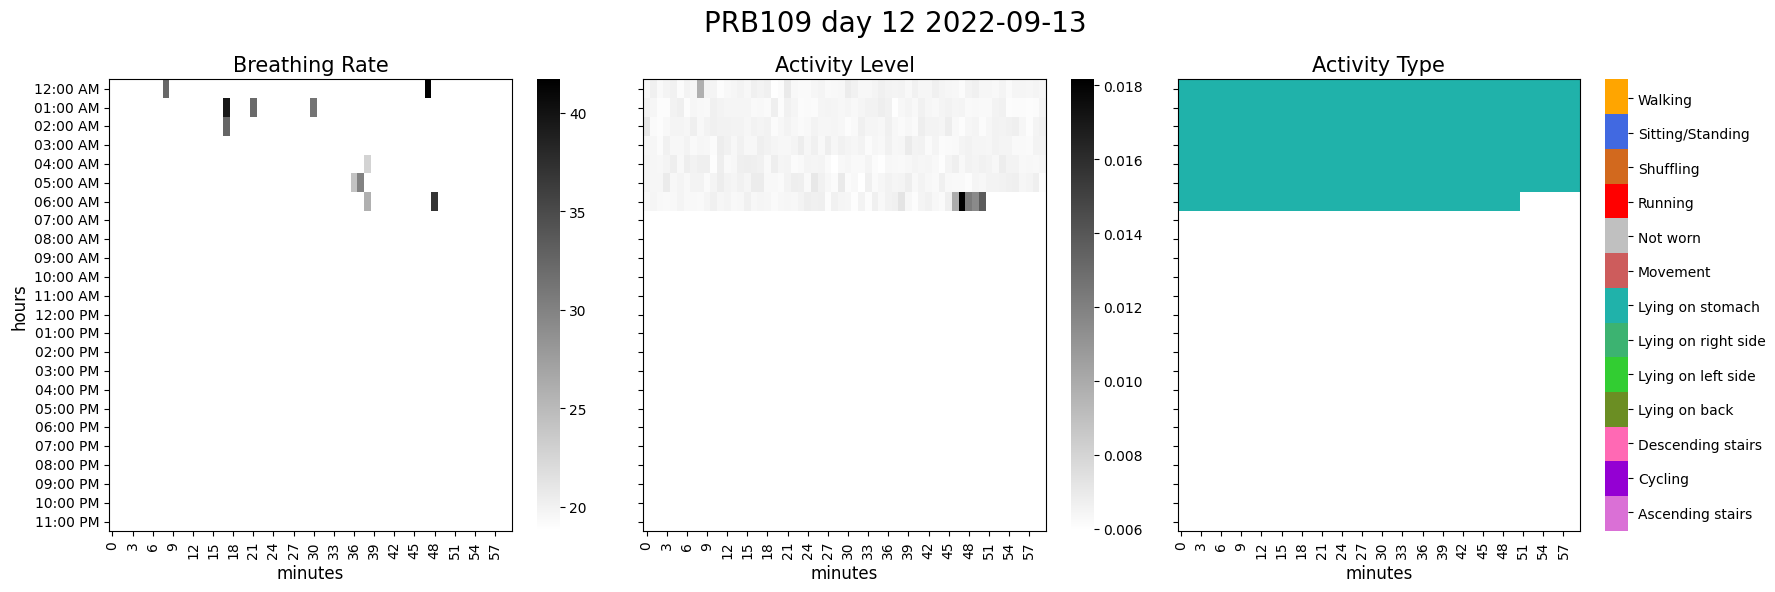

Plotting  PRB109 day 13 2022-09-15


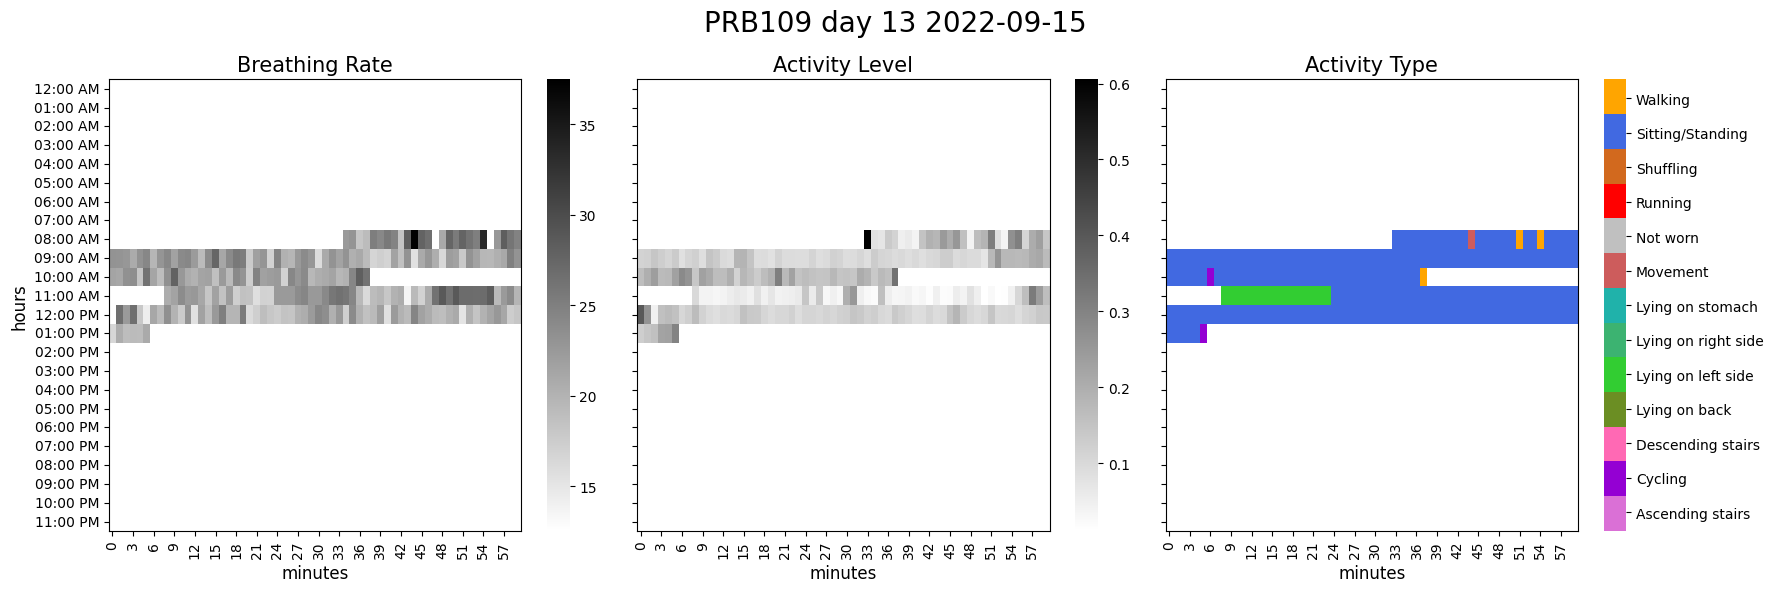

Plotting  PRB109 day 14 2022-09-17


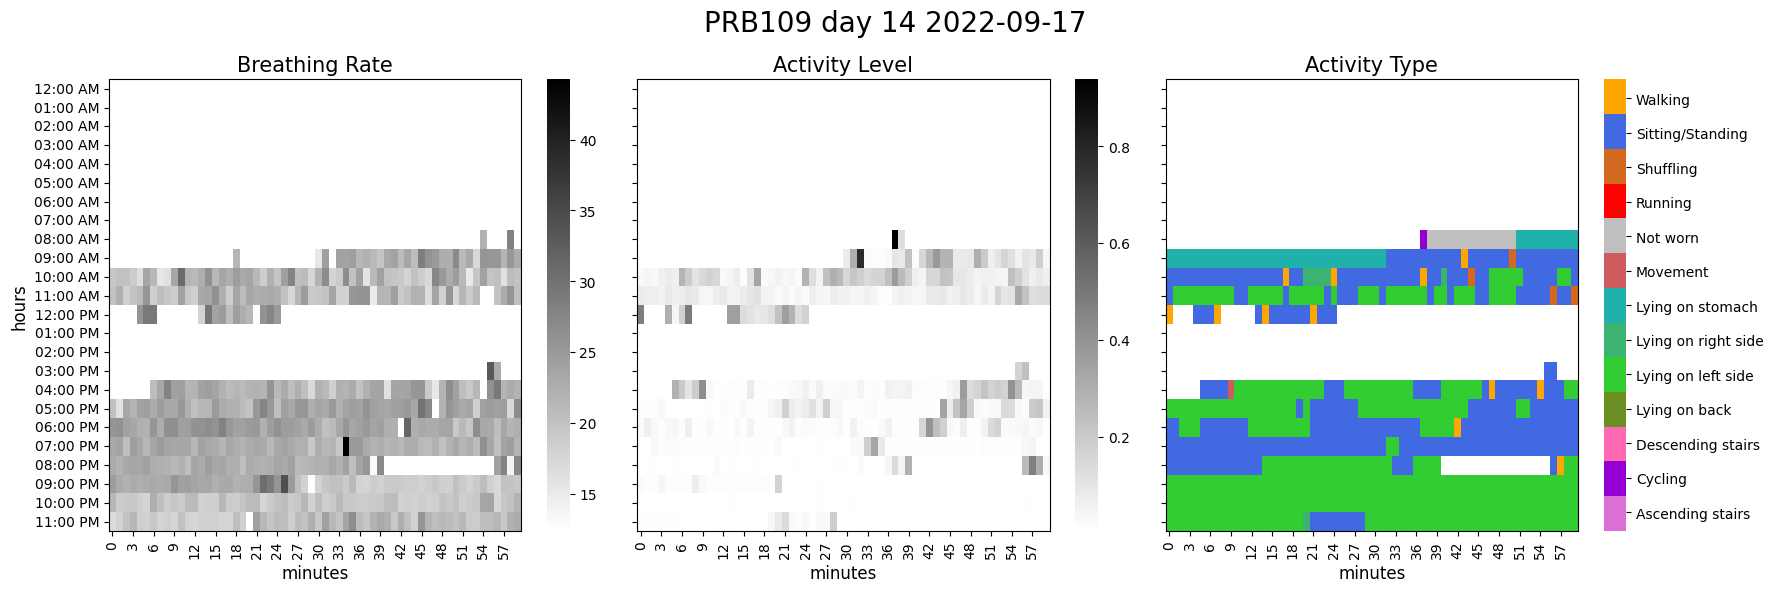

Plotting  PRB109 day 15 2022-09-18


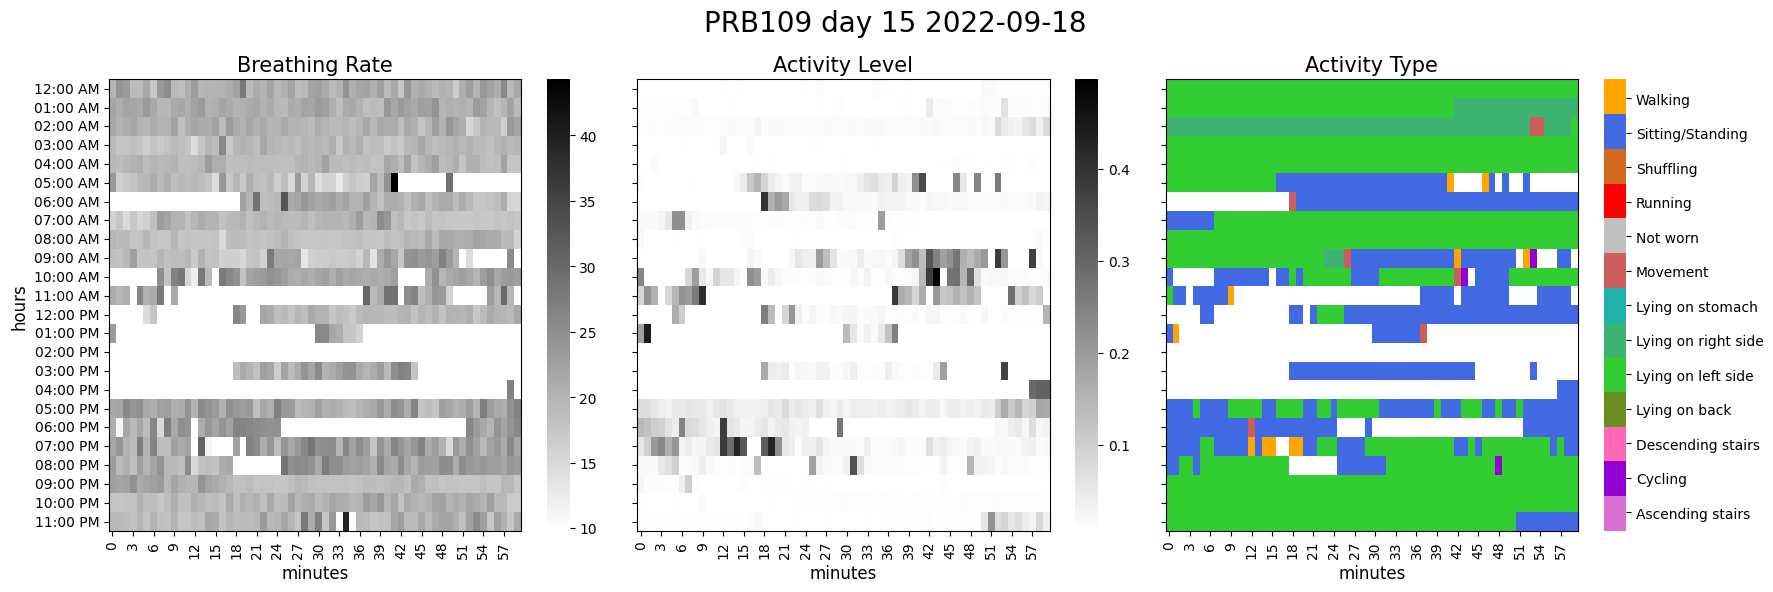

Plotting  PRB109 day 16 2022-09-19


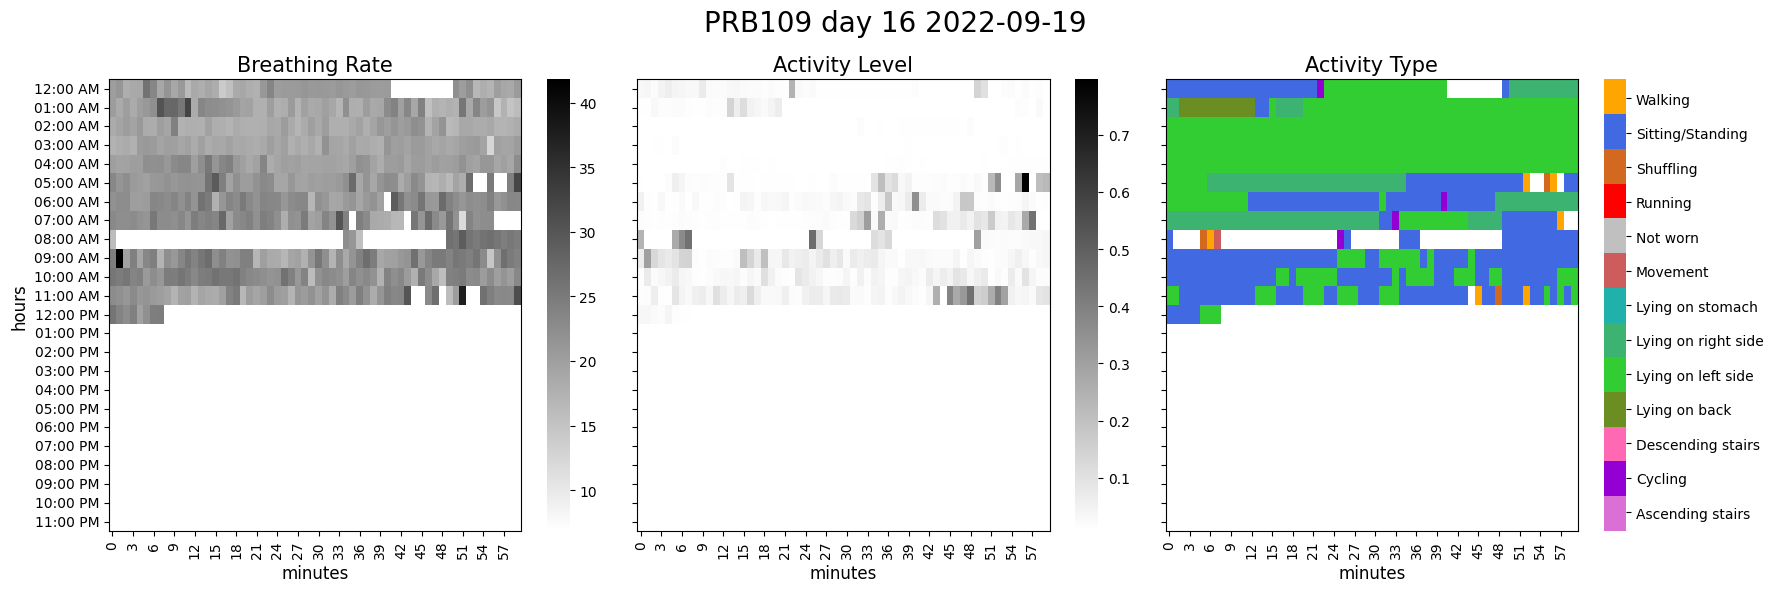

Plotting  PRB109 day 17 2022-09-20


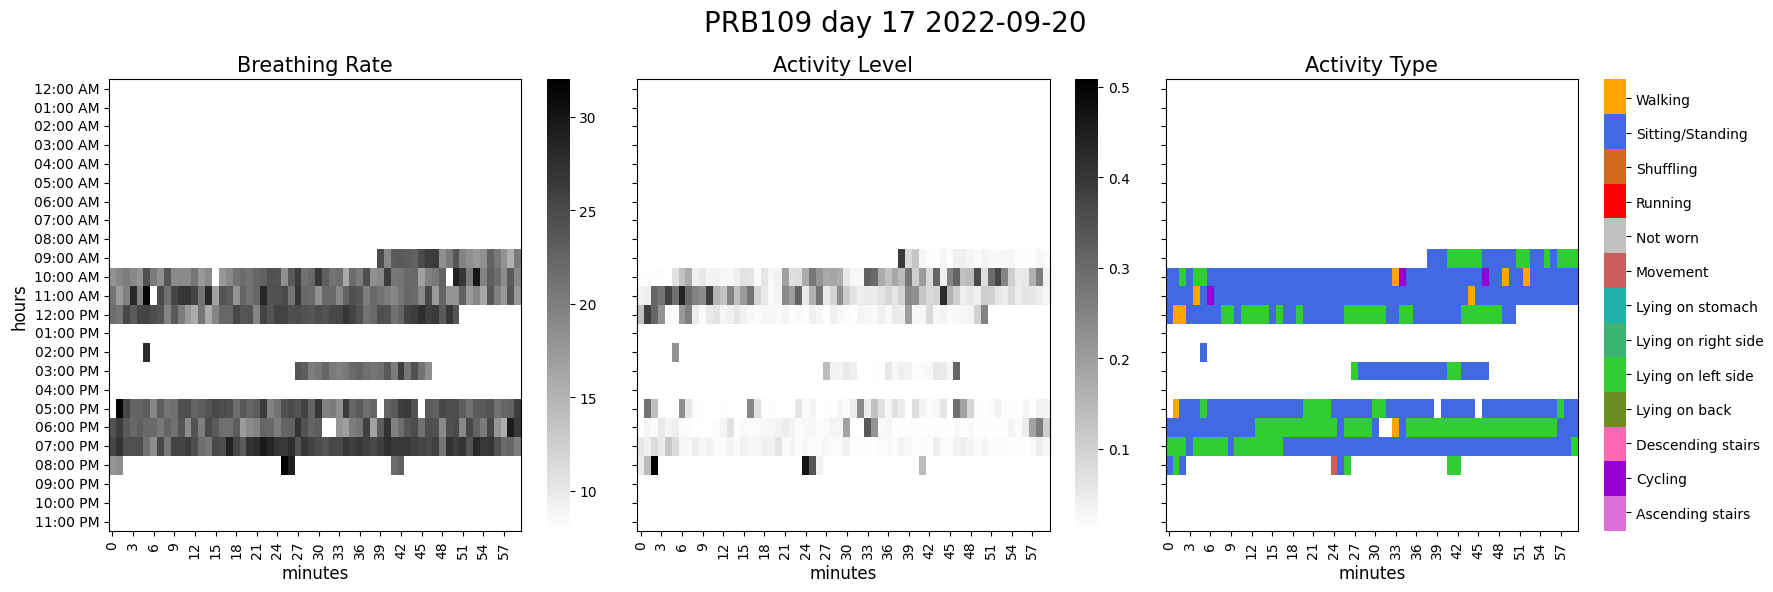

Plotting  PRB109 day 18 2022-09-21


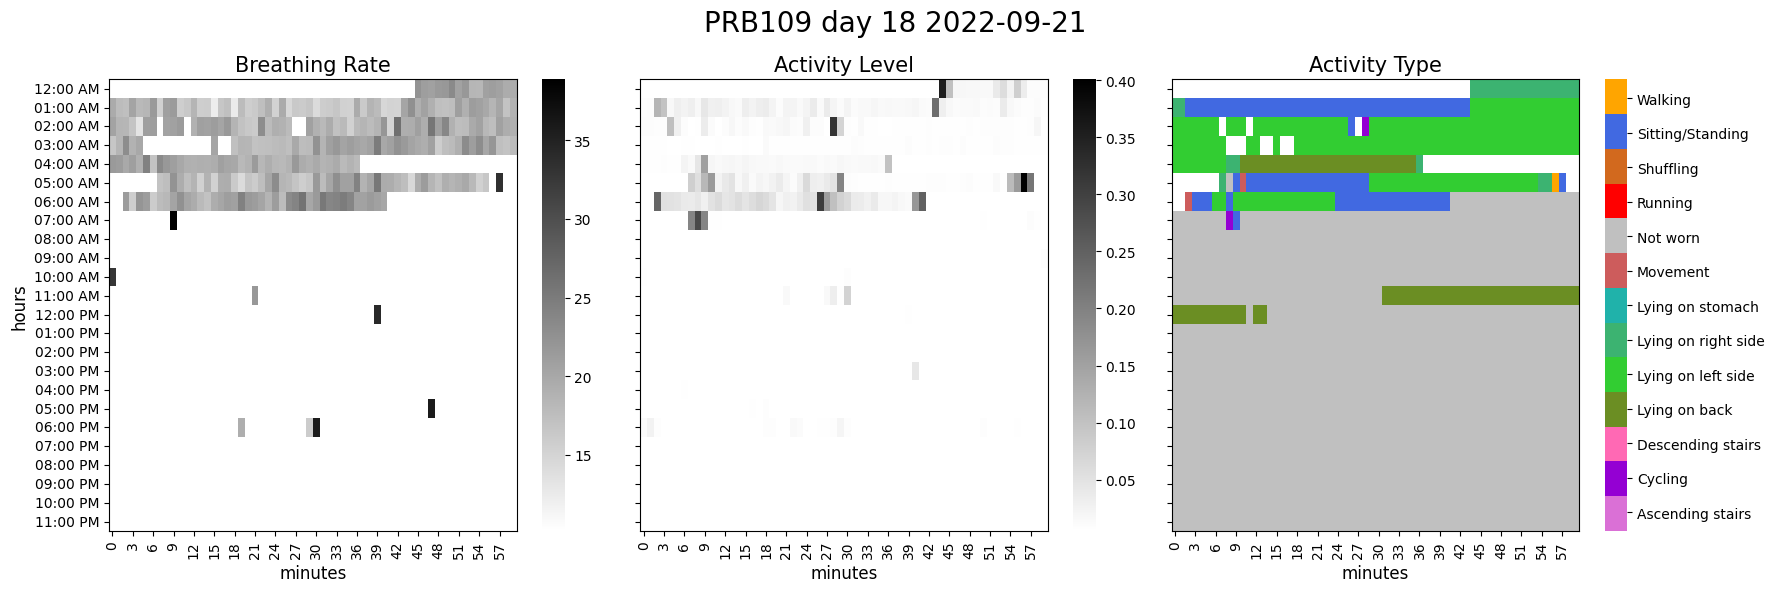

Plotting  PRB109 day 19 2022-09-22


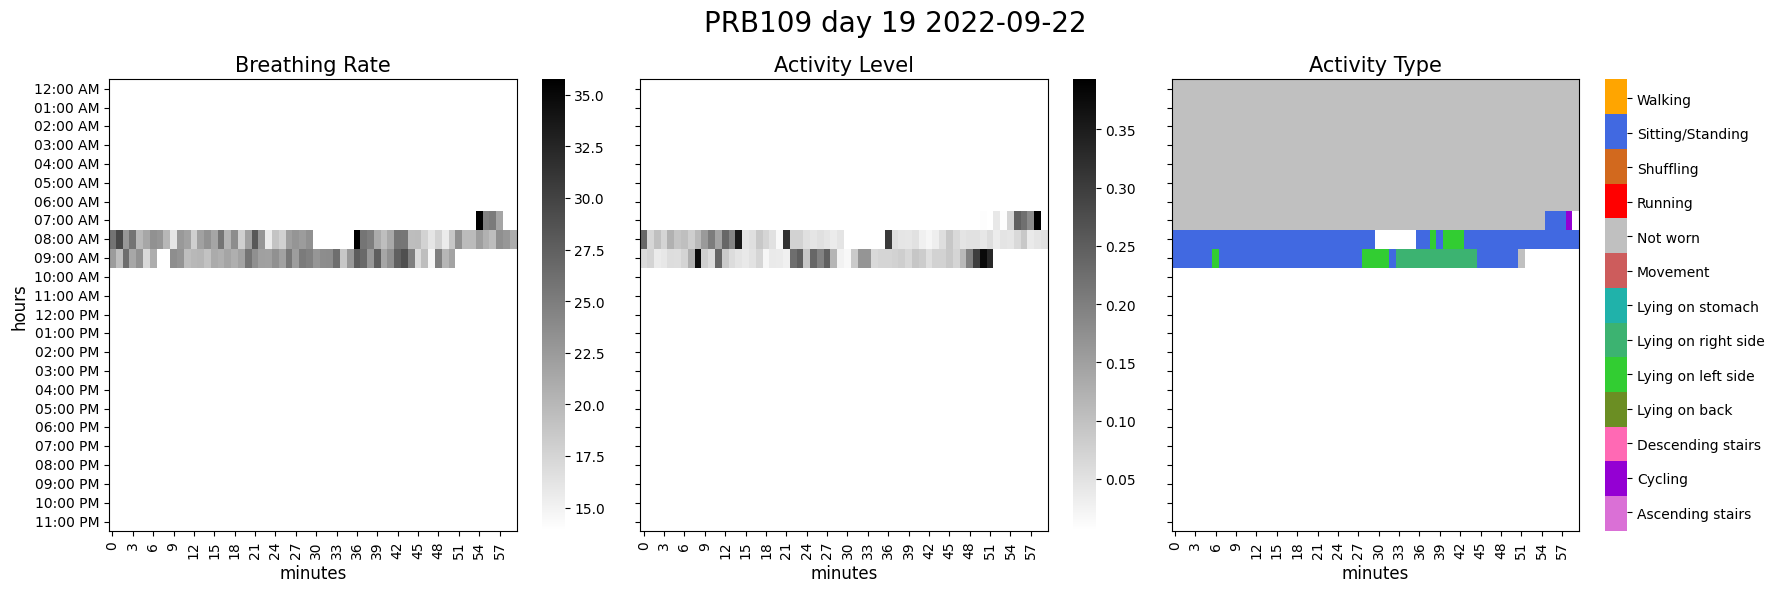

Plotting  PRB109 day 20 2022-10-10


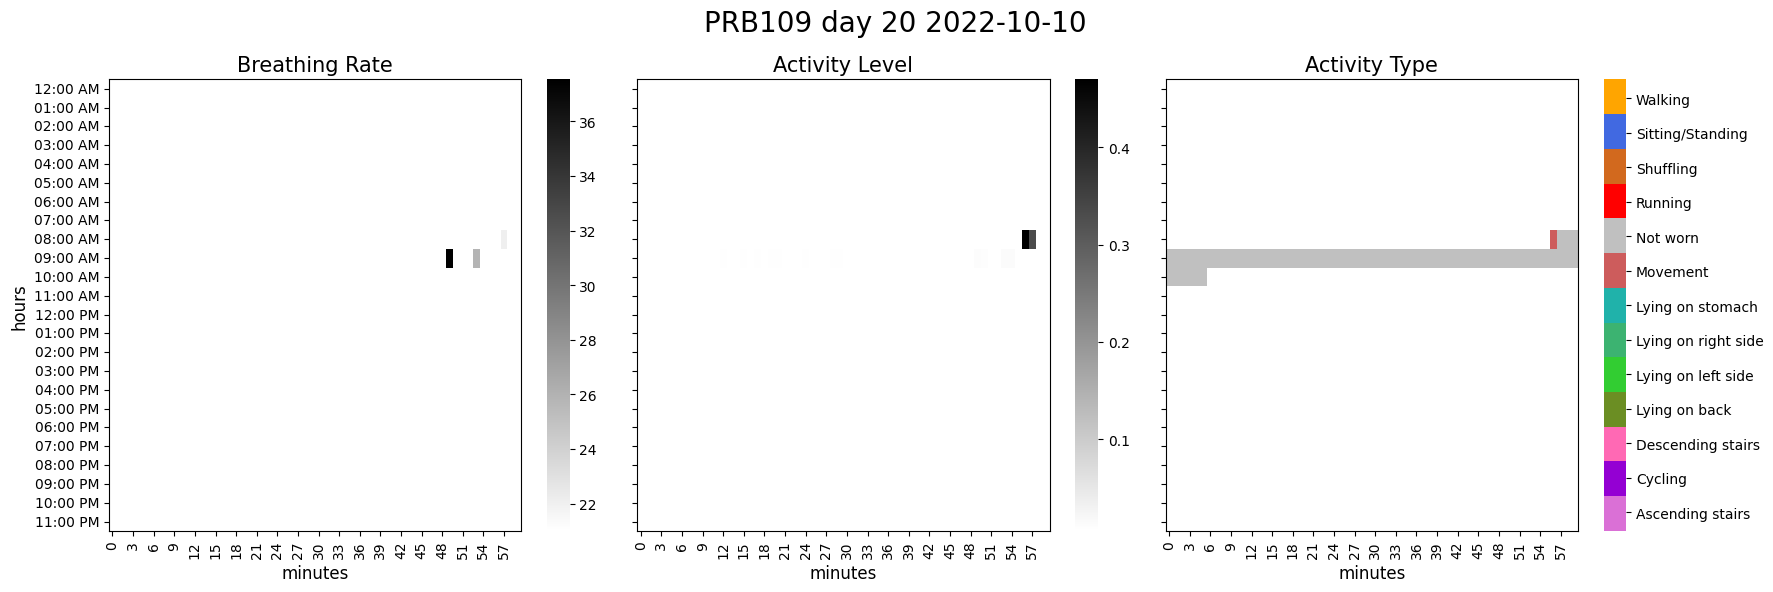

In [10]:
for i in dates:
    df = data[data['date'] == i]
    df = df[~df.index.duplicated()]
    plot_day_activity(df)

In [9]:
def plot_activity_heatmap(df, id, save=False):
    heat_map = df.groupby([df.index.date, df.index.time])["activity_type"].mean().unstack()
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(heat_map, vmin=0, vmax=12, cmap=sns.color_palette(ACTIVITY_COLOR_NUM.values()))
    ax.set_ylabel("ID")
    ax.set_xlabel("Timestamp(hrs)")
    ax.set_title(f"Activity types of {id}")
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(list(np.linspace(0.5, 11.5, 13)))
    cbar.set_ticklabels(NEW_ACTIVITY_DESCRIPTIONS.values())
    plt.tight_layout()
    if save:
        plt.savefig(f"results/NHS/graphs/activity-types/{id}.png", dpi=300)
    plt.show()

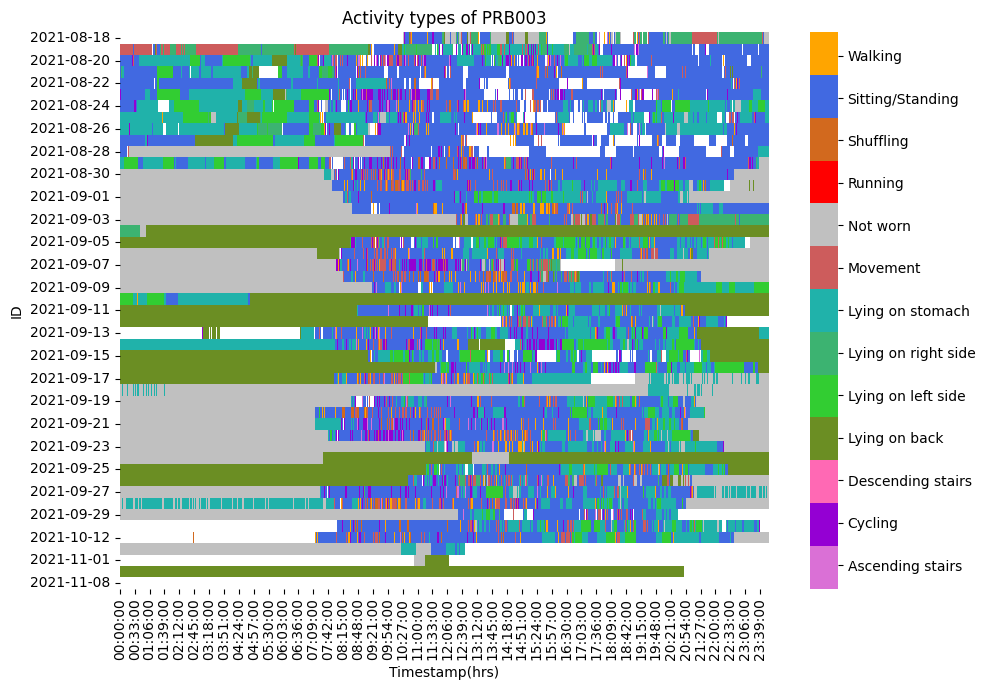

In [10]:
data = load_file("PRB003")
plot_activity_heatmap(data, "PRB003")